In [6]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('DGS10.csv')
    
df

,observation_date,DGS10
0,2020-10-09,0.79
1,2020-10-12,NaN
2,2020-10-13,0.74
3,2020-10-14,0.73
4,2020-10-15,0.74
...,...,...
1300,2025-10-03,4.13
1301,2025-10-06,4.18
1302,2025-10-07,4.14
1303,2025-10-08,4.13


Fetching 2Y treasury data from FRED...
Data fetched: 170 observations from 2025-01-14 00:00:00 to 2025-09-17 00:00:00
HIGHEST YIELD CHANGE: 7.00 basis points
  Start: Day +4 | End: Day +7 | Rows used: 6
    Ref: 2025-01-31 | Start: 2025-02-06 (4.21%) → End: 2025-02-11 (4.29%) | Change: 8.00 bps
    Ref: 2025-02-28 | Start: 2025-03-06 (3.96%) → End: 2025-03-11 (3.94%) | Change: -2.00 bps
    Ref: 2025-03-31 | Start: 2025-04-04 (3.68%) → End: 2025-04-09 (3.91%) | Change: 23.00 bps
    Ref: 2025-04-30 | Start: 2025-05-06 (3.78%) → End: 2025-05-09 (3.88%) | Change: 10.00 bps
    Ref: 2025-06-30 | Start: 2025-07-07 (3.90%) → End: 2025-07-10 (3.86%) | Change: -4.00 bps
    Ref: 2025-07-31 | Start: 2025-08-06 (3.69%) → End: 2025-08-11 (3.76%) | Change: 7.00 bps

LOWEST YIELD CHANGE: -14.00 basis points
  Start: Day -5 | End: Day +4 | Rows used: 6
    Ref: 2025-01-31 | Start: 2025-01-24 (4.27%) → End: 2025-02-06 (4.21%) | Change: -6.00 bps
    Ref: 2025-02-28 | Start: 2025-02-21 (4.19%) → End:

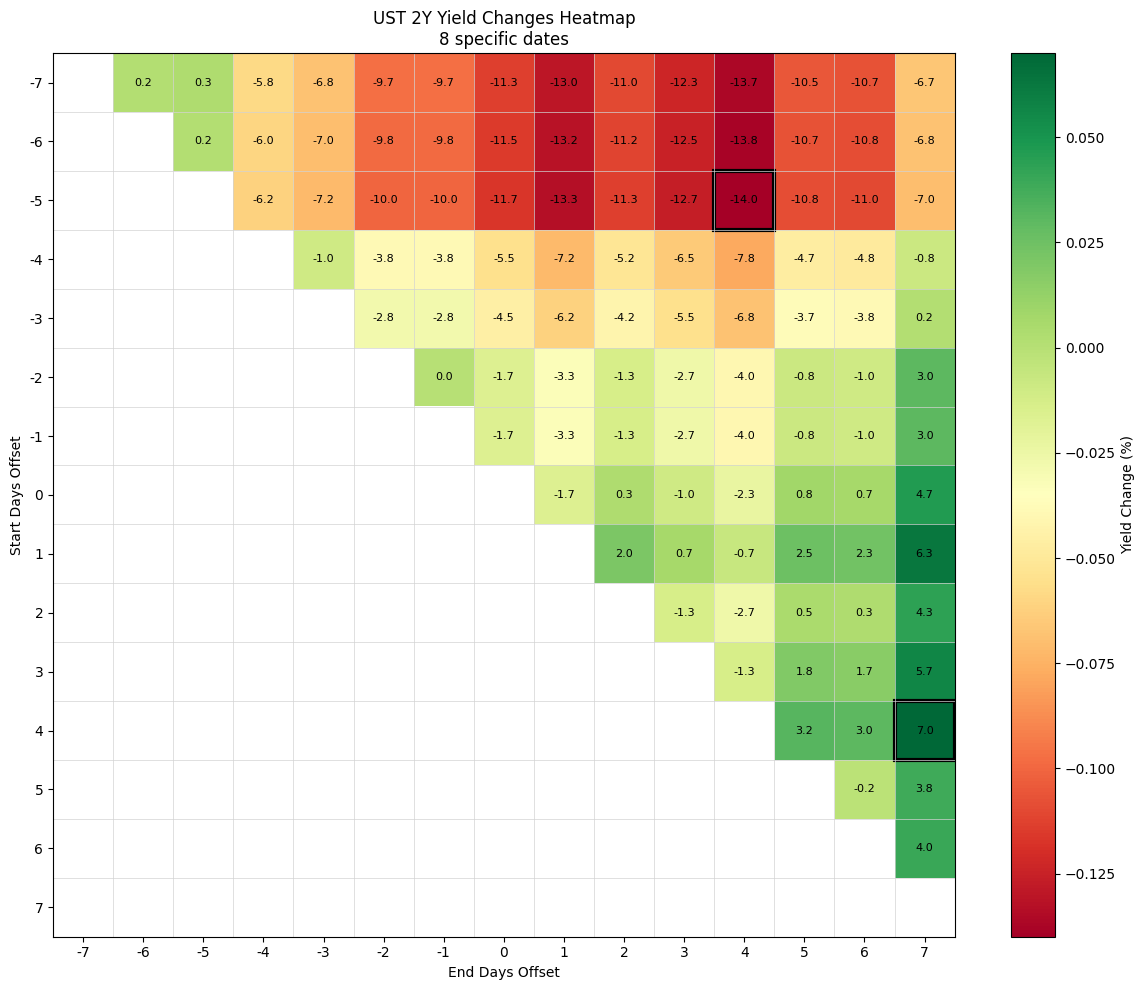

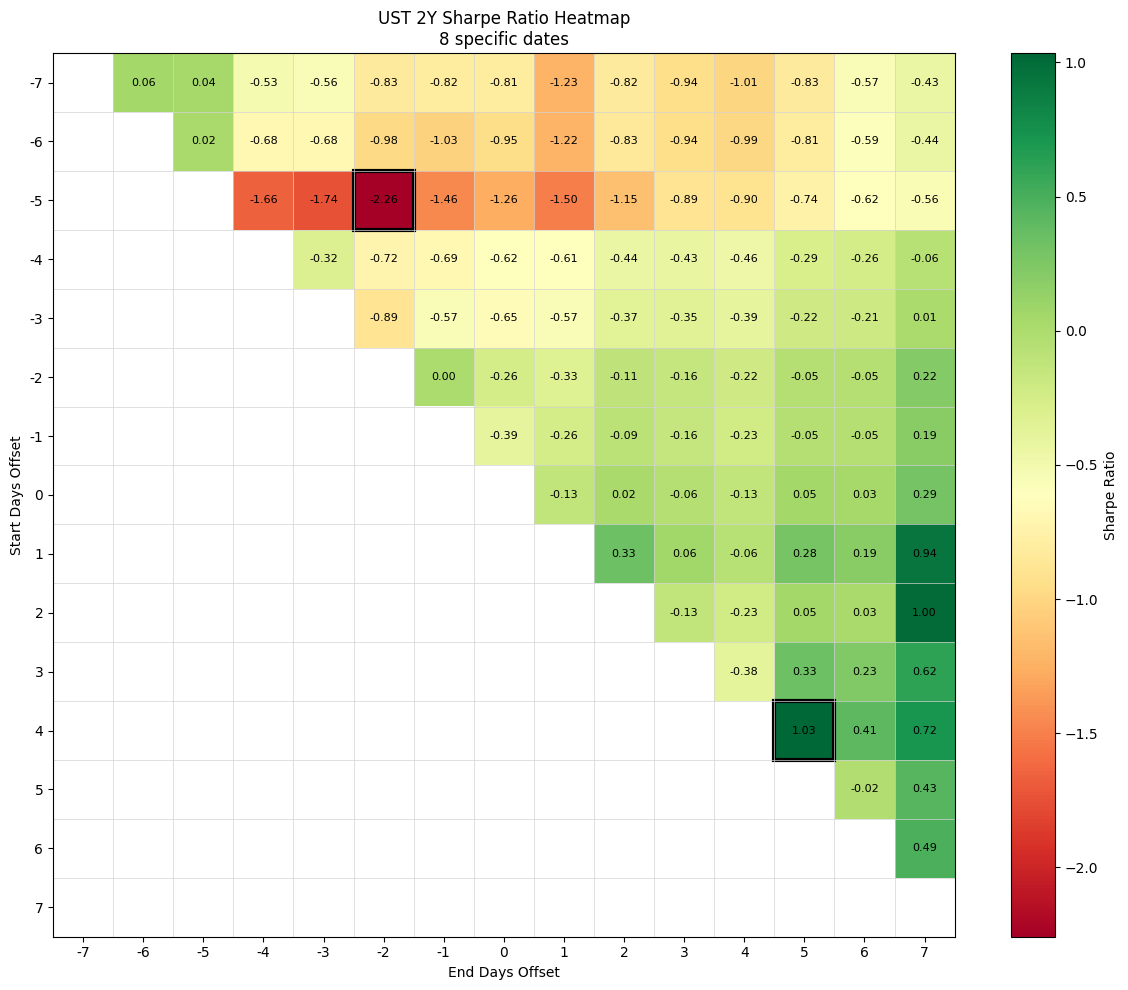

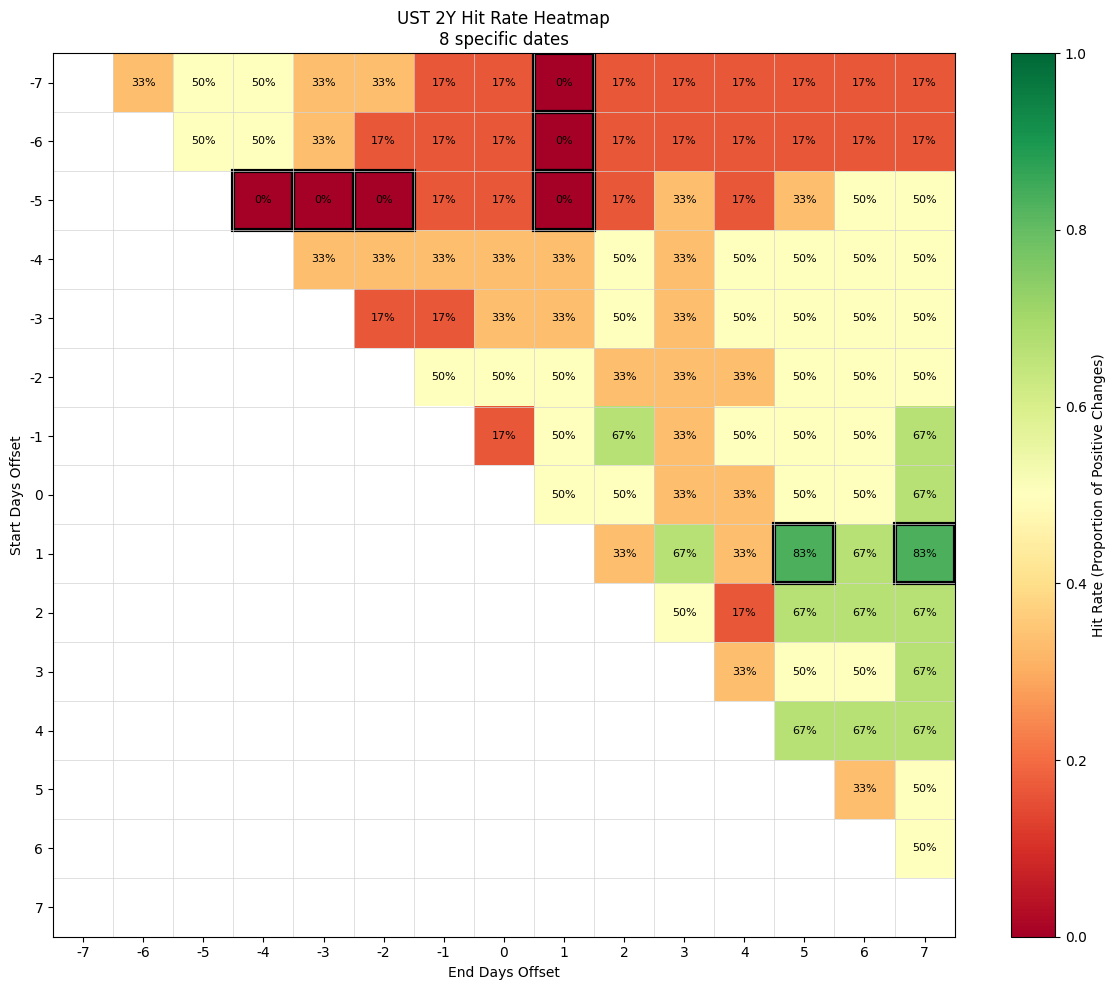

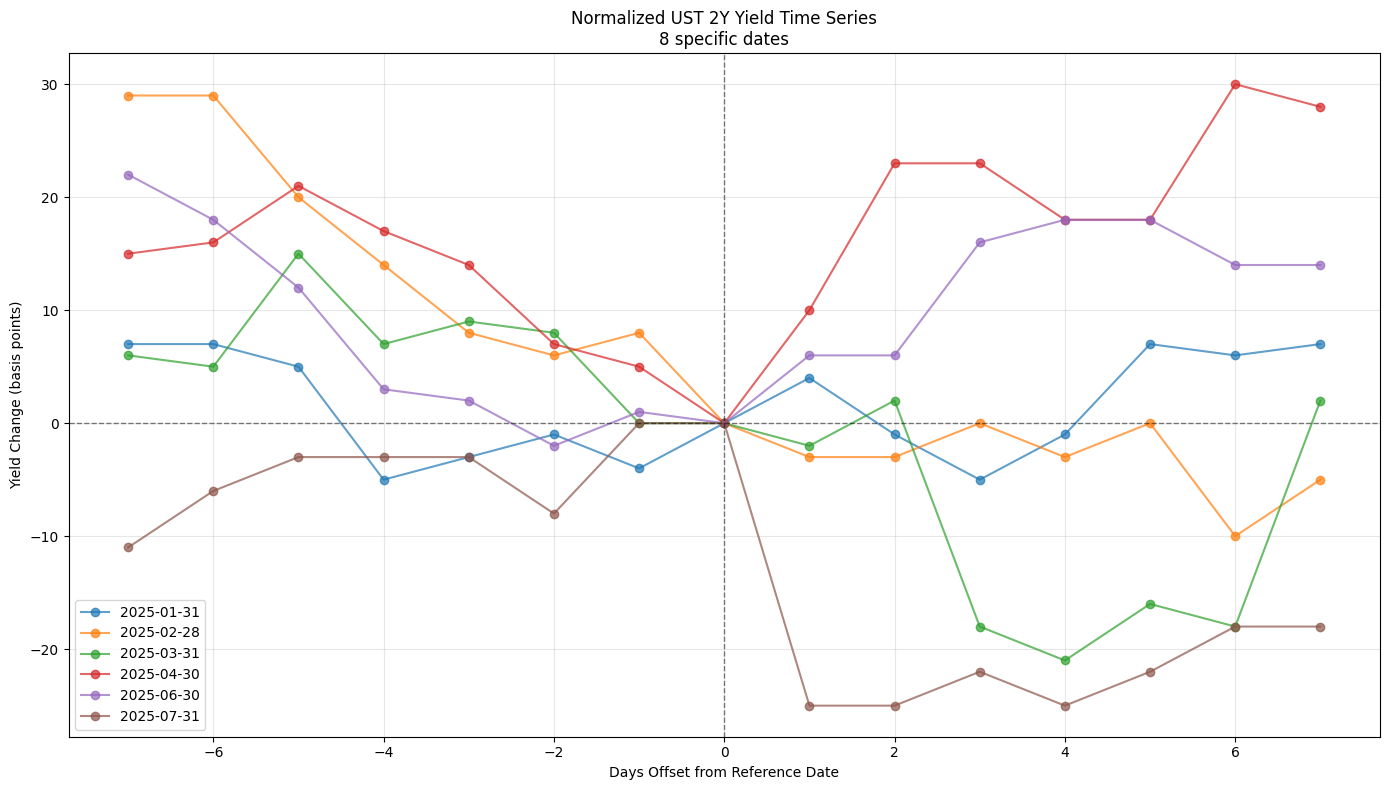

In [43]:
from matplotlib.patches import Rectangle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr

def plot_yield_changes(days_window, tenor, specific_dates, fred_api_key=None):
    """
    Plot a heatmap of yield changes for days relative to each date.
    
    Parameters:
    - days_window: int, number of days before and after each date
    - tenor: str, treasury tenor ('2Y', '3Y', '5Y', '7Y', '10Y', '20Y', '30Y')
    - specific_dates: list of str, dates to use for analysis
    - fred_api_key: str, FRED API key (optional, not used with pandas_datareader)
    """
    # Map tenor to FRED series ID
    tenor_map = {
        '2Y': 'DGS2',
        '3Y': 'DGS3',
        '5Y': 'DGS5',
        '7Y': 'DGS7',
        '10Y': 'DGS10',
        '20Y': 'DGS20',
        '30Y': 'DGS30'
    }
    
    tenor_upper = tenor.upper()
    if tenor_upper not in tenor_map:
        raise ValueError(f"Invalid tenor. Must be one of: {', '.join(tenor_map.keys())}")
    
    series_id = tenor_map[tenor_upper]
    
    # Calculate date range needed
    specific_dates_dt = pd.to_datetime(specific_dates)
    min_date = specific_dates_dt.min() - pd.Timedelta(days=days_window + 10)  # Extra buffer for weekends
    max_date = specific_dates_dt.max() + pd.Timedelta(days=days_window + 10)
    
    # Fetch data from FRED using pandas_datareader
    print(f"Fetching {tenor_upper} treasury data from FRED...")
    dataframe = pdr.DataReader(series_id, 'fred', min_date, max_date)
    
    # Convert to DataFrame format
    df_copy = pd.DataFrame({
        'observation_date': dataframe.index,
        series_id: dataframe[series_id].values
    })
    
    df_copy['observation_date'] = pd.to_datetime(df_copy['observation_date'])
    
    # Get the yield column name
    yield_col = series_id
    
    df_copy = df_copy.dropna(subset=[yield_col]).reset_index(drop=True)
    
    print(f"Data fetched: {len(df_copy)} observations from {df_copy['observation_date'].min()} to {df_copy['observation_date'].max()}")
    
    # Filter dataframe for specific dates
    df_filtered = df_copy[df_copy['observation_date'].isin(specific_dates_dt)].reset_index(drop=True)
    
    n_dates = len(df_filtered)
    window_size = 2 * days_window + 1
    change_matrix = np.zeros((window_size, window_size))
    count_matrix = np.zeros((window_size, window_size))
    
    # Store detailed trade information for highest and lowest
    trade_details = {}
    
    # Store normalized time series for each specific date
    normalized_series = {}
    
    # For each specific date
    for i in range(n_dates):
        current_date = df_filtered.loc[i, 'observation_date']
        
        # Find index in full dataframe
        current_idx = df_copy[df_copy['observation_date'] == current_date].index[0]
        
        # Extract time series for this date and normalize
        offsets = []
        yields = []
        for offset in range(-days_window, days_window + 1):
            idx = current_idx + offset
            if 0 <= idx < len(df_copy):
                offsets.append(offset)
                yields.append(df_copy.loc[idx, yield_col])
        
        if len(yields) > 0:
            # Normalize: subtract the yield at offset 0 (the reference date)
            reference_yield = df_copy.loc[current_idx, yield_col]
            normalized_yields = [y - reference_yield for y in yields]
            normalized_series[current_date] = (offsets, normalized_yields)
        
        # Calculate changes for all offset pairs relative to this specific date
        for start_offset in range(-days_window, days_window + 1):
            start_idx = current_idx + start_offset
            if 0 <= start_idx < len(df_copy):
                start_yield = df_copy.loc[start_idx, yield_col]
                start_date_val = df_copy.loc[start_idx, 'observation_date']
                
                for end_offset in range(-days_window, days_window + 1):
                    end_idx = current_idx + end_offset
                    if 0 <= end_idx < len(df_copy):
                        end_yield = df_copy.loc[end_idx, yield_col]
                        end_date_val = df_copy.loc[end_idx, 'observation_date']
                        change = end_yield - start_yield
                        
                        row = start_offset + days_window
                        col = end_offset + days_window
                        
                        # Only populate top half (where row < col) - exclude diagonal
                        if row < col:
                            key = (row, col)
                            if key not in trade_details:
                                trade_details[key] = []
                            
                            trade_details[key].append({
                                'reference_date': current_date,
                                'start_date': start_date_val,
                                'start_yield': start_yield,
                                'end_date': end_date_val,
                                'end_yield': end_yield,
                                'change': change
                            })
                            
                            change_matrix[row, col] += change
                            count_matrix[row, col] += 1
    
    # Average the changes
    change_matrix = np.divide(change_matrix, count_matrix, where=count_matrix > 0, out=np.full_like(change_matrix, np.nan))
    
    # Calculate Sharpe ratio matrix
    sharpe_matrix = np.full((window_size, window_size), np.nan)
    for i in range(window_size):
        for j in range(window_size):
            if i < j:  # Only for upper triangle
                key = (i, j)
                if key in trade_details and len(trade_details[key]) > 0:
                    changes = [detail['change'] for detail in trade_details[key]]
                    mean_change = np.mean(changes)
                    std_change = np.std(changes, ddof=1) if len(changes) > 1 else 0
                    if std_change > 0:
                        sharpe_matrix[i, j] = mean_change / std_change
    
    # Calculate hit rate matrix
    hit_rate_matrix = np.full((window_size, window_size), np.nan)
    for i in range(window_size):
        for j in range(window_size):
            if i < j:  # Only for upper triangle
                key = (i, j)
                if key in trade_details and len(trade_details[key]) > 0:
                    changes = [detail['change'] for detail in trade_details[key]]
                    positive_count = sum(1 for change in changes if change > 0)
                    hit_rate_matrix[i, j] = positive_count / len(changes)
    
    # Find highest and lowest values (excluding NaN)
    valid_mask = ~np.isnan(change_matrix)
    valid_values = change_matrix[valid_mask]
    max_val = np.max(valid_values)
    min_val = np.min(valid_values)
    max_pos = np.where((change_matrix == max_val) & valid_mask)
    min_pos = np.where((change_matrix == min_val) & valid_mask)
    
    # Print highest and lowest trade details
    print(f"{'='*80}")
    print(f"HIGHEST YIELD CHANGE: {max_val * 100:.2f} basis points")
    for i in range(len(max_pos[0])):
        row, col = max_pos[0][i], max_pos[1][i]
        start_offset = row - days_window
        end_offset = col - days_window
        key = (row, col)
        details = trade_details[key]
        print(f"  Start: Day {start_offset:+d} | End: Day {end_offset:+d} | Rows used: {len(details)}")
        for detail in details:
            print(f"    Ref: {detail['reference_date'].strftime('%Y-%m-%d')} | "
                  f"Start: {detail['start_date'].strftime('%Y-%m-%d')} ({detail['start_yield']:.2f}%) → "
                  f"End: {detail['end_date'].strftime('%Y-%m-%d')} ({detail['end_yield']:.2f}%) | "
                  f"Change: {detail['change']*100:.2f} bps")
    
    print(f"\nLOWEST YIELD CHANGE: {min_val * 100:.2f} basis points")
    for i in range(len(min_pos[0])):
        row, col = min_pos[0][i], min_pos[1][i]
        start_offset = row - days_window
        end_offset = col - days_window
        key = (row, col)
        details = trade_details[key]
        print(f"  Start: Day {start_offset:+d} | End: Day {end_offset:+d} | Rows used: {len(details)}")
        for detail in details:
            print(f"    Ref: {detail['reference_date'].strftime('%Y-%m-%d')} | "
                  f"Start: {detail['start_date'].strftime('%Y-%m-%d')} ({detail['start_yield']:.2f}%) → "
                  f"End: {detail['end_date'].strftime('%Y-%m-%d')} ({detail['end_yield']:.2f}%) | "
                  f"Change: {detail['change']*100:.2f} bps")
    print(f"{'='*80}\n")
    
    # Create heatmap - YIELD CHANGES
    plt.figure(figsize=(12, 10))
    
    # Create masked array - mask NaN values, lower triangle, AND diagonal
    mask_condition = np.isnan(change_matrix) | (np.tril(np.ones_like(change_matrix, dtype=bool), k=0))
    masked_data = np.ma.masked_where(mask_condition, change_matrix)
    
    # Create colormap with background color for masked values (flipped color scheme)
    cmap = plt.cm.RdYlGn.copy()
    cmap.set_bad(color='white')
    
    im = plt.imshow(masked_data, aspect='auto', cmap=cmap, interpolation='nearest')
    plt.colorbar(im, label='Yield Change (%)')
    plt.xlabel('End Days Offset')
    plt.ylabel('Start Days Offset')
    
    title = f'UST {tenor_upper} Yield Changes Heatmap\n{len(specific_dates)} specific dates'
    plt.title(title)
    
    plt.xticks(range(window_size), range(-days_window, days_window + 1))
    plt.yticks(range(window_size), range(-days_window, days_window + 1))
    
    # Add grid lines to create borders around each square
    ax = plt.gca()
    ax.set_xticks(np.arange(window_size) - 0.5, minor=True)
    ax.set_yticks(np.arange(window_size) - 0.5, minor=True)
    ax.grid(which='minor', color='lightgray', linestyle='-', linewidth=0.5)
    ax.tick_params(which='minor', size=0)
    
    # Add value labels (multiplied by 100 and rounded to 1 decimal place)
    for i in range(window_size):
        for j in range(window_size):
            if i < j and not np.isnan(change_matrix[i, j]):
                text = plt.text(j, i, f'{change_matrix[i, j] * 100:.1f}',
                               ha="center", va="center", color="black", fontsize=8)
    
    # Highlight highest and lowest values with thick black borders
    for i in range(len(max_pos[0])):
        row, col = max_pos[0][i], max_pos[1][i]
        rect = Rectangle((col - 0.5, row - 0.5), 1, 1, linewidth=3, 
                         edgecolor='black', facecolor='none')
        ax.add_patch(rect)
    
    for i in range(len(min_pos[0])):
        row, col = min_pos[0][i], min_pos[1][i]
        rect = Rectangle((col - 0.5, row - 0.5), 1, 1, linewidth=3, 
                         edgecolor='black', facecolor='none')
        ax.add_patch(rect)
    
    plt.tight_layout()
    plt.show()
    
    # Create heatmap - SHARPE RATIO
    plt.figure(figsize=(12, 10))
    
    # Create masked array for Sharpe ratio
    mask_condition_sharpe = np.isnan(sharpe_matrix) | (np.tril(np.ones_like(sharpe_matrix, dtype=bool), k=0))
    masked_data_sharpe = np.ma.masked_where(mask_condition_sharpe, sharpe_matrix)
    
    # Create colormap with background color for masked values
    cmap_sharpe = plt.cm.RdYlGn.copy()
    cmap_sharpe.set_bad(color='white')
    
    im_sharpe = plt.imshow(masked_data_sharpe, aspect='auto', cmap=cmap_sharpe, interpolation='nearest')
    plt.colorbar(im_sharpe, label='Sharpe Ratio')
    plt.xlabel('End Days Offset')
    plt.ylabel('Start Days Offset')
    
    title_sharpe = f'UST {tenor_upper} Sharpe Ratio Heatmap\n{len(specific_dates)} specific dates'
    plt.title(title_sharpe)
    
    plt.xticks(range(window_size), range(-days_window, days_window + 1))
    plt.yticks(range(window_size), range(-days_window, days_window + 1))
    
    # Add grid lines
    ax_sharpe = plt.gca()
    ax_sharpe.set_xticks(np.arange(window_size) - 0.5, minor=True)
    ax_sharpe.set_yticks(np.arange(window_size) - 0.5, minor=True)
    ax_sharpe.grid(which='minor', color='lightgray', linestyle='-', linewidth=0.5)
    ax_sharpe.tick_params(which='minor', size=0)
    
    # Add value labels for Sharpe ratio
    for i in range(window_size):
        for j in range(window_size):
            if i < j and not np.isnan(sharpe_matrix[i, j]):
                text = plt.text(j, i, f'{sharpe_matrix[i, j]:.2f}',
                               ha="center", va="center", color="black", fontsize=8)
    
    # Find and highlight highest and lowest Sharpe ratios
    valid_mask_sharpe = ~np.isnan(sharpe_matrix)
    if np.any(valid_mask_sharpe):
        valid_sharpe = sharpe_matrix[valid_mask_sharpe]
        max_sharpe = np.max(valid_sharpe)
        min_sharpe = np.min(valid_sharpe)
        max_sharpe_pos = np.where((sharpe_matrix == max_sharpe) & valid_mask_sharpe)
        min_sharpe_pos = np.where((sharpe_matrix == min_sharpe) & valid_mask_sharpe)
        
        for i in range(len(max_sharpe_pos[0])):
            row, col = max_sharpe_pos[0][i], max_sharpe_pos[1][i]
            rect = Rectangle((col - 0.5, row - 0.5), 1, 1, linewidth=3, 
                             edgecolor='black', facecolor='none')
            ax_sharpe.add_patch(rect)
        
        for i in range(len(min_sharpe_pos[0])):
            row, col = min_sharpe_pos[0][i], min_sharpe_pos[1][i]
            rect = Rectangle((col - 0.5, row - 0.5), 1, 1, linewidth=3, 
                             edgecolor='black', facecolor='none')
            ax_sharpe.add_patch(rect)
    
    plt.tight_layout()
    plt.show()
    
    # Create heatmap - HIT RATE
    plt.figure(figsize=(12, 10))
    
    # Create masked array for hit rate
    mask_condition_hit = np.isnan(hit_rate_matrix) | (np.tril(np.ones_like(hit_rate_matrix, dtype=bool), k=0))
    masked_data_hit = np.ma.masked_where(mask_condition_hit, hit_rate_matrix)
    
    # Create colormap with background color for masked values
    cmap_hit = plt.cm.RdYlGn.copy()
    cmap_hit.set_bad(color='white')
    
    im_hit = plt.imshow(masked_data_hit, aspect='auto', cmap=cmap_hit, interpolation='nearest', vmin=0, vmax=1)
    plt.colorbar(im_hit, label='Hit Rate (Proportion of Positive Changes)')
    plt.xlabel('End Days Offset')
    plt.ylabel('Start Days Offset')
    
    title_hit = f'UST {tenor_upper} Hit Rate Heatmap\n{len(specific_dates)} specific dates'
    plt.title(title_hit)
    
    plt.xticks(range(window_size), range(-days_window, days_window + 1))
    plt.yticks(range(window_size), range(-days_window, days_window + 1))
    
    # Add grid lines
    ax_hit = plt.gca()
    ax_hit.set_xticks(np.arange(window_size) - 0.5, minor=True)
    ax_hit.set_yticks(np.arange(window_size) - 0.5, minor=True)
    ax_hit.grid(which='minor', color='lightgray', linestyle='-', linewidth=0.5)
    ax_hit.tick_params(which='minor', size=0)
    
    # Add value labels for hit rate (as percentage)
    for i in range(window_size):
        for j in range(window_size):
            if i < j and not np.isnan(hit_rate_matrix[i, j]):
                text = plt.text(j, i, f'{hit_rate_matrix[i, j] * 100:.0f}%',
                               ha="center", va="center", color="black", fontsize=8)
    
    # Find and highlight highest and lowest hit rates
    valid_mask_hit = ~np.isnan(hit_rate_matrix)
    if np.any(valid_mask_hit):
        valid_hit = hit_rate_matrix[valid_mask_hit]
        max_hit = np.max(valid_hit)
        min_hit = np.min(valid_hit)
        max_hit_pos = np.where((hit_rate_matrix == max_hit) & valid_mask_hit)
        min_hit_pos = np.where((hit_rate_matrix == min_hit) & valid_mask_hit)
        
        for i in range(len(max_hit_pos[0])):
            row, col = max_hit_pos[0][i], max_hit_pos[1][i]
            rect = Rectangle((col - 0.5, row - 0.5), 1, 1, linewidth=3, 
                             edgecolor='black', facecolor='none')
            ax_hit.add_patch(rect)
        
        for i in range(len(min_hit_pos[0])):
            row, col = min_hit_pos[0][i], min_hit_pos[1][i]
            rect = Rectangle((col - 0.5, row - 0.5), 1, 1, linewidth=3, 
                             edgecolor='black', facecolor='none')
            ax_hit.add_patch(rect)
    
    plt.tight_layout()
    plt.show()
    
    # Create normalized time series plot
    plt.figure(figsize=(14, 8))
    
    for current_date, (offsets, normalized_yields) in normalized_series.items():
        plt.plot(offsets, [y * 100 for y in normalized_yields], 
                marker='o', label=current_date.strftime('%Y-%m-%d'), alpha=0.7)
    
    plt.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    plt.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    plt.xlabel('Days Offset from Reference Date')
    plt.ylabel('Yield Change (basis points)')
    plt.title(f'Normalized UST {tenor_upper} Yield Time Series\n{len(specific_dates)} specific dates')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# Example usage:
plot_yield_changes(7, '2Y', specific_dates=['2025-01-31',
 '2025-02-28',
 '2025-03-31',
 '2025-04-30',
 '2025-05-31',
 '2025-06-30',
 '2025-07-31',
 '2025-08-31'])
